In [ ]:
import pandas as pd

from attributes.marginal_data_reader import read_marginal_data
from data_tools.static_mappings import specific_to_grouped_attained_education_map, specific_to_grouped_education_map


The next step in our synthetic population is to add the attribute for _absolved_ education, or the highest level of education completed by each agent.

Similar to the `current_education` category, we have to construct this data set from multiple sources that are available.

First of all, it should be clear that the current and absolved education are related. An agent currently enrolled in a university master most likely will not be enrolled in primary education.

Secondly, the marginal data on the neighborhood level only provides three different levels of education: `low`, `middle` and `high`.

Third, there is a dataset available that describes absolved education conditioned on age and gender[^1]. This data set can be exported using 
[8 different categories](https://opendata.cbs.nl/#/CBS/nl/dataset/85453NED/table?dl=9EDBE).

While it is clear how the categories used in `current_education` can be mapped to the three levels (CBS defined these themselves), we will have to see if the 8 categories overlap as well.

Another limitation of this data set is that for the ages 0 to 15 years old, no information is provided. This may be easy to fill in, but it has to be filled in, nonetheless.

The purpose of this notebook is to create a data set that can be used as the source for adding absolved education to the synthetic population, addressing all these issues.

[^1]: This data is further conditioned on country of birth. CBS is moving to reporting this instead of migration background. Country of birth following similar categories as the migration background was included in the downloaded data set, but the mapping between the two attributes may not correlate sufficiently, and will therefor not be included. Because `current_education` _is_ conditioned on migration background, and in this notebook we will attempt to condition `absolved_education` on `current_education`, we hope this condition emerges on its own.

# Reading the data

In [ ]:
def preprocess_absolved_education(df: pd.DataFrame) -> pd.DataFrame:
    df.drop(['Perioden', 'Geboorteland (ouders)', 'Herkomstland'], axis=1, inplace=True)
    df.rename(columns={
        'Geslacht': 'gender', 'Leeftijd': 'age', 'Onderwijsniveau': 'absolved_education', 'Bevolking (x 1000)': 'count'
    }, inplace=True)
    df["count"] *= 1000
    df.replace({
        'Mannen': 'male', 'Vrouwen': 'female', 'Nederland': 'Dutch',
        '1 Laag onderwijsniveau': 'low', '2 Middelbaar onderwijsniveau': 'middle',
        '3 Hoog onderwijsniveau': 'high', 'Weet niet of onbekend': 'unknown'
    }, inplace=True)
    age_map = {f'{i} tot {i + 10} jaar': f"{i}-{i + 10}" for i in range(15, 75, 10)}
    age_map['75 jaar of ouder'] = '75+'
    df.age = df.age.map(age_map)
    df = df.groupby(['age', 'gender', 'absolved_education']).sum().reset_index()

    return df

In [ ]:
df_8_levels = preprocess_absolved_education(
        pd.read_csv(
                "../../../../datasources/individual/education/Bevolking__onderwijsniveau_en_herkomst_26012024_115001.csv",
                sep=";"))

In [ ]:
df_margins = read_marginal_data(['education_absolved_low', 'education_absolved_middle', 'education_absolved_high'],
                                'absolved_education')

In [ ]:
df_current_education = pd.read_pickle('../processed/prepared_current_education.pkl')

# The current levels of education
The current education data has (after we manipulated it, see [the other notebook](current_education.ipynb)) the following 18 categories of education:

In [ ]:
df_current_education.current_education.unique()

array(['Basisonderwijs', 'Speciaal basisonderwijs', 'Speciale scholen',
       'Vo algemene leerjaren 1-3', 'Vwo 3-6', 'Havo 3-5',
       'Vmbo theoretische-gemengde leerweg 3-4',
       'Vmbo basis-kaderberoeps 3-4', 'Praktijkonderwijs', 'Vavo',
       'Assistentopleiding (niveau 1)',
       'Basisberoepsopleiding (niveau 2)', 'Vakopleiding (niveau 3)',
       'Middenkaderopleiding (niveau 4a)',
       'Specialistenopleiding (niveau 4b)', 'Hoger beroepsonderwijs',
       'Wetenschappelijk onderwijs', 'not_enrolled'], dtype=object)

CBS classifies these into `low`, `middle` and `high` education as follows:

In [ ]:
levels = {level: [edu for edu, lvl in specific_to_grouped_education_map.items() if lvl == level] for level in
          ['primary', 'low', 'middle', 'high']}
max_length = max(len(l) for l in levels.values())
for level, edu in levels.items():
    levels[level] = edu + [""] * (max_length - len(edu))

pd.DataFrame(levels)

,primary,low,middle,high
0,Basisonderwijs,Vo algemene leerjaren 1-3,Vwo 3-6,Hoger beroepsonderwijs
1,Speciaal basisonderwijs,Vmbo theoretische-gemengde leerweg 3-4,Havo 3-5,Wetenschappelijk onderwijs
2,Speciale scholen,Vmbo basis-kaderberoeps 3-4,Vavo,
3,,Praktijkonderwijs,Mbo bol,
4,,Assistentopleiding (niveau 1),Mbo bbl,
5,,,Basisberoepsopleiding (niveau 2),
6,,,Vakopleiding (niveau 3),
7,,,Middenkaderopleiding (niveau 4a),
8,,,Specialistenopleiding (niveau 4b),


Of course, we have added the three categories for primary education from another data set. This could be considered a `low` level of education, or be kept separate.

Given that we are aiming to find out what the highest level of absolved education is going to be, based on an agents current education, it is useful to get an overview how the various categories relate.

As we have seen, a student starts in primary education, usually at the age of 4 or 5. This phase typically takes 8 years, but the actually taken time can deviate (1 year in either direction in the majority of cases that deviate). We can assume students in primary education do not have any level of absolved education.

What happens after primary school is a bit more complex. Dutch primary school _De Toverlaars_ [have created a helpful diagram](https://www.toverlaars.schoolsunited.nu/index.php?section=11&page=204) showing how one can broadly progress through the various levels of education. They skip a bit over MBO level of education, which actually encapsulates multiple different levels of education in our `current_education` data set. 
Kidswiki.nl show [this overview](https://wikikids.nl/Voorbereidend_middelbaar_beroepsonderwijs) with [this diagram](https://upload.wikimedia.org/wikipedia/commons/6/6e/Doorstroomvmboenmbo.svg) specifically showing the progression through the various stages of MBO.

Based on these resources, the following diagram shows the most typical progression paths through these 20 categories of education:
![typical progression opportunities through current education levels](../../../doc/figures/education-flow.png)

The colors indicate how CBS classifies all these different categories as either `low,`, `middle` or `high` (`primary` was not included in that CBS data, so had been added as a separate category).

# The 8 levels of _absolved_ education
The data for _absolved_ education uses 8 instead of 18 attributes:

In [ ]:
df_8_levels.absolved_education.unique()

array(['111 Basisonderwijs', '121 Vmbo-b/k, mbo1',
       '122 Vmbo-g/t, havo-, vwo-onderbouw', '211 Mbo2 en mbo3',
       '212 Mbo4', '213 Havo, vwo', '311 Hbo-, wo-bachelor',
       '321 Hbo-, wo-master, doctor', 'unknown'], dtype=object)

These levels group some of the other levels together. We can reconstruct the typical flow through these levels as follows:

![Typical flow through the 8 levels of Education](../../../../doc/figures/education-flow-8cat.png)

The purpose of this notebook is to add a condition on current education. If we can find a mapping between the 18 and 8 categories, perhaps we can do this. The mapping (and its flow) looks like this:

![Typical flow through the combined levels of education](../../../../doc/figures/education-flow-levels-combined.png)

Here, the filled boxes show the 18 categories from the current education. The outlined boxes are the 8 categories from absolved education, which wrap the 18 more detailed categories

This is a very useful diagram, because it tells us for each of the detailed current education categories which of the 8 less detailed category allowed the agents to enroll in that program. In other words, the most likely absolved education for a student is the group that they have had to complete to enter that level.

For example, the entire second row (`Praktijkonderwijs`, `Assistentenopleiding (Niveau 1)` `Vmbo basis-kaderberoeps 3-4`, `Vmbo theoretische-gemengte leerweg 3-4` and `Vo algemene leerjaren 1-3`) will have absolved education `Basisonderwijs` (primary education). This leads us to conclude that the entire group of `Basisonderwijs` will be assigned to agents in one of these 5 groups + the `not_enrolled` group. The numbers we will condition on will be proportional to the proportions of agents in each of these 5+1 groups.

Special attention to the `Vavo` group from current education. This is a way for adults to complete their high school diploma (`VMBO theoretische leerweg`, `Havo 3-5` or `VWO 3-6`). This sounds complicated, but suggests agents currently enrolled in `Vavo` have `Basisonderwijs` as their highest level of absolved education as well.

Some groups will be more complex, however.

First, the group `Mbo2 en Mbo3` can contain both agents with absolved education `Vmbo-b/k, mbo1` (through `Assistentnopleiding (niveau 1`) or `Mbo2 en mbo3` itself (through `Basisberoepsopleiding (niveau 2)`).

Secondly, high education is grouped differently (current education distinguishes applied and academic sciences while absolved education distinguishes only bachelor's and master's programs), so we will need to figure out how to resolve those groups.

Lastly, the data specifies a group of unknown absolved education. This group could be interpreted as not educated at all, or, since most people will finish primary education (due to compulsory learning laws) as having completed at most primary school, but since the defined semantics is that we have no idea about this group, that would be imposing assumptions on the data, which we want to minimize. It appears that this group is very small, anyway: 

In [ ]:
df_8_levels.pivot(index=['age', 'gender'], columns='absolved_education', values='count')

absolved_education  111 Basisonderwijs  121 Vmbo-b/k, mbo1  \
age   gender                                                 
15-25 female                    104000               97000   
      male                      142000              134000   
25-35 female                     32000               52000   
      male                       31000               66000   
35-45 female                     43000               57000   
      male                       51000               85000   
45-55 female                     66000              106000   
      male                       70000              138000   
55-65 female                    101000              151000   
      male                       91000              151000   
65-75 female                    137000              201000   
      male                       86000              144000   
75+   female                    169000              187000   
      male                       70000              119000   

absolved_education  122 Vmbo-g/t, havo-, vwo-onderbouw  211 Mbo2 en mbo3  \
age   gender                                                               
15-25 female                                    221000             72000   
      male                                      229000             91000   
25-35 female                                     33000            125000   
      male                                       41000            172000   
35-45 female                                     44000            128000   
      male                                       35000            144000   
45-55 female                                     80000            183000   
      male                                       54000            191000   
55-65 female                                    115000            200000   
      male                                       52000            194000   
65-75 female                                    123000            156000   
      male                                       54000            190000   
75+   female                                     84000             98000   
      male                                       38000            114000   

absolved_education  212 Mbo4  213 Havo, vwo  311 Hbo-, wo-bachelor  \
age   gender                                                         
15-25 female          127000         267000                 128000   
      male             98000         271000                  88000   
25-35 female          179000          67000                 350000   
      male            178000         102000                 316000   
35-45 female          177000          61000                 282000   
      male            164000          70000                 258000   
45-55 female          259000          84000                 270000   
      male            221000          89000                 259000   
55-65 female          142000         103000                 228000   
      male            162000          79000                 244000   
65-75 female           82000          55000                 152000   
      male             92000          59000                 190000   
75+   female           35000          39000                  77000   
      male             45000          27000                  85000   

absolved_education  321 Hbo-, wo-master, doctor  unknown  
age   gender                                              
15-25 female                              19000     3000  
      male                                14000     7000  
25-35 female                             235000    11000  
      male                               181000    13000  
35-45 female                             206000    19000  
      male                               182000    21000  
45-55 female                             157000    21000  
      male                               177000    23000  
55-65 female                             107000    20000  
      male          

For this reason, we will completely ignore the `unknown` category, and only focus on the known levels of absolved education.

In [ ]:
df_8_levels = df_8_levels[df_8_levels.absolved_education != "unknown"]

# Time to start adding current education condition
It is time to start adding the current education condition. We will do this per each of the 8 categories absolved education provides.

## Matching age groups
The shared conditional attributes of current and absolved education are age and gender. However, the data sets do not use the same age groups, so we will have to correct that first

In [ ]:
age_map = {
              f'{i}-{i + 5}': f'{i}-{i + 10}' for i in range(15, 75, 10)
          } | {
              f'{i}-{i + 5}': f'{i - 5}-{i + 5}' for i in range(20, 80, 10)
          } | {
              f'{i}': f'{(i - 5) // 10 * 10 + 5}-{(i - 5) // 10 * 10 + 15}' for i in range(30)
          } | {f'{i}-{i + 5}': '75+' for i in range(75, 95, 5)} | {'95+': '75+'}
age_map

{'15-20': '15-25',
 '25-30': '25-35',
 '35-40': '35-45',
 '45-50': '45-55',
 '55-60': '55-65',
 '65-70': '65-75',
 '20-25': '15-25',
 '30-35': '25-35',
 '40-45': '35-45',
 '50-55': '45-55',
 '60-65': '55-65',
 '70-75': '65-75',
 '0': '-5-5',
 '1': '-5-5',
 '2': '-5-5',
 '3': '-5-5',
 '4': '-5-5',
 '5': '5-15',
 '6': '5-15',
 '7': '5-15',
 '8': '5-15',
 '9': '5-15',
 '10': '5-15',
 '11': '5-15',
 '12': '5-15',
 '13': '5-15',
 '14': '5-15',
 '15': '15-25',
 '16': '15-25',
 '17': '15-25',
 '18': '15-25',
 '19': '15-25',
 '20': '15-25',
 '21': '15-25',
 '22': '15-25',
 '23': '15-25',
 '24': '15-25',
 '25': '25-35',
 '26': '25-35',
 '27': '25-35',
 '28': '25-35',
 '29': '25-35',
 '75-80': '75+',
 '80-85': '75+',
 '85-90': '75+',
 '90-95': '75+',
 '95+': '75+'}

In [ ]:
df_edu_mapped = df_current_education.copy()
df_edu_mapped.age = df_edu_mapped.age.replace(age_map)
df_edu_mapped = df_edu_mapped[~df_edu_mapped.age.isin(['-5-5', '5-15', '0-4'])]
df_edu_mapped = df_edu_mapped.drop('migration_background', axis=1).groupby(
        ['age', 'gender', 'current_education']).sum().reset_index()
df_edu_mapped.set_index(['age', 'gender'], inplace=True)
df_edu_mapped

current_education         count
age   gender                                                      
15-25 female           Assistentopleiding (niveau 1)    186.000000
      female        Basisberoepsopleiding (niveau 2)   1081.000000
      female                          Basisonderwijs      0.000000
      female                                Havo 3-5   1799.000000
      female                  Hoger beroepsonderwijs   6554.000000
...                                              ...           ...
75+   male    Vmbo theoretische-gemengde leerweg 3-4      0.000000
      male                 Vo algemene leerjaren 1-3      0.000000
      male                                   Vwo 3-6      0.000000
      male                Wetenschappelijk onderwijs      5.372908
      male                              not_enrolled  12977.407545

[252 rows x 2 columns]

## Proportions of `not enrolled`
We also have to think about what level of absolved education will be assigned to the `not_enrolled` group, because we have no information about their current education, so they could theoretically already have finished the highest level.

Within each group of `age` $\times$ `gender`, we will calculate the relative proportion of each of the 8 absolved education levels, and assume that proportion is maintained within the `not_enrolled` group.   

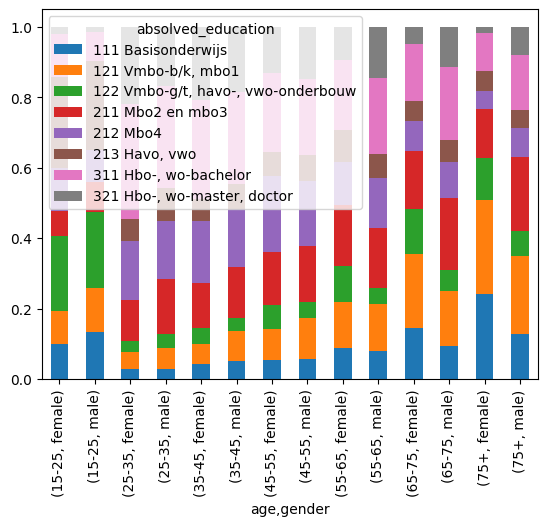

In [ ]:
df_relative_size = df_8_levels.copy()
df_relative_size.loc[:, "relative_size"] = df_8_levels.groupby(['age', 'gender'])["count"].transform(
        lambda x: x / x.sum())
df_relative_size.pivot(
        index=['age', 'gender'], columns='absolved_education', values='relative_size'
).plot(kind='bar', stacked=True)
df_relative_size.set_index(['age', 'gender'], inplace=True)

# Basisonderwijs (primary education)
We will start by adding the conditions for absolved education level of primary school (`Basisonderwijs`):

In [ ]:
df_absolved_primary = df_8_levels[df_8_levels.absolved_education == '111 Basisonderwijs'].set_index(['age', 'gender'])
df_absolved_primary

absolved_education   count
age   gender                            
15-25 female  111 Basisonderwijs  104000
      male    111 Basisonderwijs  142000
25-35 female  111 Basisonderwijs   32000
      male    111 Basisonderwijs   31000
35-45 female  111 Basisonderwijs   43000
      male    111 Basisonderwijs   51000
45-55 female  111 Basisonderwijs   66000
      male    111 Basisonderwijs   70000
55-65 female  111 Basisonderwijs  101000
      male    111 Basisonderwijs   91000
65-75 female  111 Basisonderwijs  137000
      male    111 Basisonderwijs   86000
75+   female  111 Basisonderwijs  169000
      male    111 Basisonderwijs   70000

As we reasoned, the semantics of highest level of absolved education is that they have not yet finished any other form of education. This includes people still enrolled in an education program that (typically) directly follows primary education, or perhaps people not currently enrolled in education. 

In [ ]:
after_primary_list = [
    'Assistentopleiding (niveau 1)',
    'Basisberoepsopleiding (niveau 2)',
    'Praktijkonderwijs',
    'Vavo',
    'Vmbo basis-kaderberoeps 3-4',
    'Vmbo theoretische-gemengde leerweg 3-4',
    'Vo algemene leerjaren 1-3',
    'not_enrolled'
]
df_edu_mapped_primary = df_edu_mapped[df_edu_mapped.current_education.isin(after_primary_list)]
assert len(after_primary_list) == len(df_edu_mapped_primary.current_education.unique())  # Safeguard against misspelling
df_edu_mapped_primary

current_education         count
age   gender                                                      
15-25 female           Assistentopleiding (niveau 1)    186.000000
      female        Basisberoepsopleiding (niveau 2)   1081.000000
      female                       Praktijkonderwijs    314.000000
      female                                    Vavo    227.000000
      female             Vmbo basis-kaderberoeps 3-4    987.000000
...                                              ...           ...
75+   male                                      Vavo      0.544548
      male               Vmbo basis-kaderberoeps 3-4      0.000000
      male    Vmbo theoretische-gemengde leerweg 3-4      0.000000
      male                 Vo algemene leerjaren 1-3      0.000000
      male                              not_enrolled  12977.407545

[112 rows x 2 columns]

Now we need to update the value for `not_enrolled` by multiplying it with the relative proportion of `Basisonderwijs` within each gender and age group, so that we can divide the `not_enrolled` condition proportionally:

In [ ]:
df_edu_mapped_primary.loc[
    df_edu_mapped_primary.current_education == "not_enrolled", "count"
] *= df_relative_size[df_relative_size.absolved_education == "111 Basisonderwijs"]["relative_size"]
df_edu_mapped_primary.loc[:, ["fraction"]] = df_edu_mapped_primary.groupby(level=[0, 1])["count"].transform(
        lambda x: x / x.sum())
df_edu_mapped_primary = df_edu_mapped_primary.drop(columns=['count'])
df_edu_mapped_primary

current_education  fraction
age   gender                                                  
15-25 female           Assistentopleiding (niveau 1)  0.038255
      female        Basisberoepsopleiding (niveau 2)  0.222331
      female                       Praktijkonderwijs  0.064581
      female                                    Vavo  0.046687
      female             Vmbo basis-kaderberoeps 3-4  0.202998
...                                              ...       ...
75+   male                                      Vavo  0.000324
      male               Vmbo basis-kaderberoeps 3-4  0.000000
      male    Vmbo theoretische-gemengde leerweg 3-4  0.000000
      male                 Vo algemene leerjaren 1-3  0.000000
      male                              not_enrolled  0.998806

[112 rows x 2 columns]

In [ ]:
df_edu_absolved_primary_conditioned = df_absolved_primary.merge(df_edu_mapped_primary, left_index=True,
                                                                right_index=True, how='inner')
df_edu_absolved_primary_conditioned.loc[:,
"count"] = df_edu_absolved_primary_conditioned["count"] * df_edu_absolved_primary_conditioned.fraction
df_edu_absolved_primary_conditioned.drop('fraction', axis=1, inplace=True)
df_edu_absolved_primary_conditioned

absolved_education         count  \
age   gender                                     
15-25 female  111 Basisonderwijs   3978.504474   
      female  111 Basisonderwijs  23122.383529   
      female  111 Basisonderwijs   6716.400026   
      female  111 Basisonderwijs   4855.486643   
      female  111 Basisonderwijs  21111.741483   
...                          ...           ...   
75+   male    111 Basisonderwijs     22.673932   
      male    111 Basisonderwijs      0.000000   
      male    111 Basisonderwijs      0.000000   
      male    111 Basisonderwijs      0.000000   
      male    111 Basisonderwijs  69916.400541   

                                   current_education  
age   gender                                          
15-25 female           Assistentopleiding (niveau 1)  
      female        Basisberoepsopleiding (niveau 2)  
      female                       Praktijkonderwijs  
      female                                    Vavo  
      female             Vmbo basis-kaderberoeps 3-4  
...                                              ...  
75+   male                                      Vavo  
      male               Vmbo basis-kaderberoeps 3-4  
      male    Vmbo theoretische-gemengde leerweg 3-4  
      male                 Vo algemene leerjaren 1-3  
      male                              not_enrolled  

[112 rows x 3 columns]

# Vmbo-b/k
Now all the current education categories that have finished `Vmbo-b/k`. Let's take a look at the diagram again:

![diagram-again](../../../../doc/figures/education-flow-levels-combined.png)

`Vmbo-b/lk` contains three types of education: `Praktijkonderwijs` (after which people will usually go to `not_enrolled`), `Assistentenopleiding (niveau 1)` (after which people usually move to `Basisberoepsonderwijs (niveau 2)`) and `Vmbo basis-kaderberoeps 3-4` (after which people usually move to `Middenkaderopleiding (niveau 4a)`.

We assume all agents that have current education `Basisberoepsonderwijs (niveau 2)` will come from `Vmbo-b/k, mbo1`. We will assume a fraction of the `not_enrolled` agents also come from this group, using the same proportional approach as before. For the last category, `Middenkaderopleiding (niveau 4a)`, some agents will come from this group, and other agents from the other `Vmbo theoretisch gemengde leerweg 3-4`. Let's assume these will be proportional as well:

In [ ]:
df_kader_tl_fractions = df_edu_mapped.loc[df_edu_mapped.current_education.isin(
        ['Vmbo basis-kaderberoeps 3-4', 'Vmbo theoretische-gemengde leerweg 3-4']
)]
df_kader_tl_fractions.loc[:, ["fractions"]] = df_kader_tl_fractions.groupby(level=[0, 1])["count"].transform(
        lambda x: x / x.sum()).fillna(.5)
df_kader_tl_fractions


current_education   count  fractions
age   gender                                                           
15-25 female             Vmbo basis-kaderberoeps 3-4   987.0   0.497229
      female  Vmbo theoretische-gemengde leerweg 3-4   998.0   0.502771
      male               Vmbo basis-kaderberoeps 3-4  1199.0   0.521304
      male    Vmbo theoretische-gemengde leerweg 3-4  1101.0   0.478696
25-35 female             Vmbo basis-kaderberoeps 3-4     0.0   0.500000
      female  Vmbo theoretische-gemengde leerweg 3-4     0.0   0.500000
      male               Vmbo basis-kaderberoeps 3-4     0.0   0.500000
      male    Vmbo theoretische-gemengde leerweg 3-4     0.0   0.500000
35-45 female             Vmbo basis-kaderberoeps 3-4     0.0   0.500000
      female  Vmbo theoretische-gemengde leerweg 3-4     0.0   0.500000
      male               Vmbo basis-kaderberoeps 3-4     0.0   0.500000
      male    Vmbo theoretische-gemengde leerweg 3-4     0.0   0.500000
45-55 female             Vmbo basis-kaderberoeps 3-4     0.0   0.500000
      female  Vmbo theoretische-gemengde leerweg 3-4     0.0   0.500000
      male               Vmbo basis-kaderberoeps 3-4     0.0   0.500000
      male    Vmbo theoretische-gemengde leerweg 3-4     0.0   0.500000
55-65 female             Vmbo basis-kaderberoeps 3-4     0.0   0.500000
      female  Vmbo theoretische-gemengde leerweg 3-4     0.0   0.500000
      male               Vmbo basis-kaderberoeps 3-4     0.0   0.500000
      male    Vmbo theoretische-gemengde leerweg 3-4     0.0   0.500000
65-75 female             Vmbo basis-kaderberoeps 3-4     0.0   0.500000
      female  Vmbo theoretische-gemengde leerweg 3-4     0.0   0.500000
      male               Vmbo basis-kaderberoeps 3-4     0.0   0.500000
      male    Vmbo theoretische-gemengde leerweg 3-4     0.0   0.500000
75+   female             Vmbo basis-kaderberoeps 3-4     0.0   0.500000
      female  Vmbo theoretische-gemengde leerweg 3-4     0.0   0.500000
      male               Vmbo basis-kaderberoeps 3-4     0.0   0.500000
      male    Vmbo theoretische-gemengde leerweg 3-4     0.0   0.500000

Here, we only need the fraction for `Vmbo basis-kaderberoeps 3-4`, but it appears no agents over the age of 35 are enrolled according to our original data. Since the proportions appear to be around 0.5, that is the value we replace the missing proportions with. 

In [ ]:
df_edu_mapped_mbo1 = df_edu_mapped[df_edu_mapped.current_education.isin(
        ['not_enrolled', 'Basisberoepsopleiding (niveau 2)', 'Middenkaderopleiding (niveau 4a)'])]

# Adjust not_enrolled according to fraction
df_edu_mapped_mbo1.loc[
    df_edu_mapped_mbo1.current_education == "not_enrolled", "count"
] *= df_relative_size[df_relative_size.absolved_education == "121 Vmbo-b/k, mbo1"]["relative_size"]

# Adjust middenkader 4a values
df_edu_mapped_mbo1.loc[
    df_edu_mapped_mbo1.current_education == "Middenkaderopleiding (niveau 4a)", "count"
] *= df_kader_tl_fractions[df_kader_tl_fractions.current_education == "Vmbo basis-kaderberoeps 3-4"]["fractions"]

df_edu_mapped_mbo1.loc[:, ["fraction"]] = df_edu_mapped_mbo1.groupby(level=[0, 1])["count"].transform(
        lambda x: x / x.sum())
df_edu_mapped_mbo1 = df_edu_mapped_mbo1.drop(columns=['count'])

df_edu_mapped_mbo1

current_education  fraction
age   gender                                            
15-25 female  Basisberoepsopleiding (niveau 2)  0.300499
      female  Middenkaderopleiding (niveau 4a)  0.487643
      female                      not_enrolled  0.211858
      male    Basisberoepsopleiding (niveau 2)  0.374928
      male    Middenkaderopleiding (niveau 4a)  0.365339
      male                        not_enrolled  0.259733
25-35 female  Basisberoepsopleiding (niveau 2)  0.051624
      female  Middenkaderopleiding (niveau 4a)  0.078375
      female                      not_enrolled  0.870001
      male    Basisberoepsopleiding (niveau 2)  0.081433
      male    Middenkaderopleiding (niveau 4a)  0.037210
      male                        not_enrolled  0.881357
35-45 female  Basisberoepsopleiding (niveau 2)  0.008444
      female  Middenkaderopleiding (niveau 4a)  0.020667
      female                      not_enrolled  0.970889
      male    Basisberoepsopleiding (niveau 2)  0.011195
      male    Middenkaderopleiding (niveau 4a)  0.007807
      male                        not_enrolled  0.980997
45-55 female  Basisberoepsopleiding (niveau 2)  0.003416
      female  Middenkaderopleiding (niveau 4a)  0.005666
      female                      not_enrolled  0.990918
      male    Basisberoepsopleiding (niveau 2)  0.001763
      male    Middenkaderopleiding (niveau 4a)  0.001780
      male                        not_enrolled  0.996457
55-65 female  Basisberoepsopleiding (niveau 2)  0.000979
      female  Middenkaderopleiding (niveau 4a)  0.001642
      female                      not_enrolled  0.997379
      male    Basisberoepsopleiding (niveau 2)  0.001158
      male    Middenkaderopleiding (niveau 4a)  0.000469
      male                        not_enrolled  0.998373
65-75 female  Basisberoepsopleiding (niveau 2)  0.000546
      female  Middenkaderopleiding (niveau 4a)  0.001008
      female                      not_enrolled  0.998446
      male    Basisberoepsopleiding (niveau 2)  0.000792
      male    Middenkaderopleiding (niveau 4a)  0.000426
      male                        not_enrolled  0.998782
75+   female  Basisberoepsopleiding (niveau 2)  0.000384
      female  Middenkaderopleiding (niveau 4a)  0.000780
      female                      not_enrolled  0.998836
      male    Basisberoepsopleiding (niveau 2)  0.000484
      male    Middenkaderopleiding (niveau 4a)  0.000319
      male                        not_enrolled  0.999198

In [ ]:
df_edu_absolved_mbo1_conditioned = df_8_levels[df_8_levels.absolved_education == '121 Vmbo-b/k, mbo1'].set_index(
        ['age', 'gender']
).merge(df_edu_mapped_mbo1, left_index=True, right_index=True, how='inner')

df_edu_absolved_mbo1_conditioned.loc[:,
"count"] = df_edu_absolved_mbo1_conditioned["count"] * df_edu_absolved_mbo1_conditioned.fraction
df_edu_absolved_mbo1_conditioned.drop('fraction', axis=1, inplace=True)
df_edu_absolved_mbo1_conditioned

absolved_education          count  \
age   gender                                      
15-25 female  121 Vmbo-b/k, mbo1   29148.367250   
      female  121 Vmbo-b/k, mbo1   47301.374062   
      female  121 Vmbo-b/k, mbo1   20550.258689   
      male    121 Vmbo-b/k, mbo1   50240.322342   
      male    121 Vmbo-b/k, mbo1   48955.446035   
      male    121 Vmbo-b/k, mbo1   34804.231623   
25-35 female  121 Vmbo-b/k, mbo1    2684.465244   
      female  121 Vmbo-b/k, mbo1    4075.506326   
      female  121 Vmbo-b/k, mbo1   45240.028430   
      male    121 Vmbo-b/k, mbo1    5374.565362   
      male    121 Vmbo-b/k, mbo1    2455.842067   
      male    121 Vmbo-b/k, mbo1   58169.592571   
35-45 female  121 Vmbo-b/k, mbo1     481.332262   
      female  121 Vmbo-b/k, mbo1    1177.997377   
      female  121 Vmbo-b/k, mbo1   55340.670361   
      male    121 Vmbo-b/k, mbo1     951.600197   
      male    121 Vmbo-b/k, mbo1     663.615927   
      male    121 Vmbo-b/k, mbo1   83384.783876   
45-55 female  121 Vmbo-b/k, mbo1     362.097992   
      female  121 Vmbo-b/k, mbo1     600.564861   
      female  121 Vmbo-b/k, mbo1  105037.337147   
      male    121 Vmbo-b/k, mbo1     243.329659   
      male    121 Vmbo-b/k, mbo1     245.635602   
      male    121 Vmbo-b/k, mbo1  137511.034739   
55-65 female  121 Vmbo-b/k, mbo1     147.862831   
      female  121 Vmbo-b/k, mbo1     247.940611   
      female  121 Vmbo-b/k, mbo1  150604.196558   
      male    121 Vmbo-b/k, mbo1     174.843710   
      male    121 Vmbo-b/k, mbo1      70.761450   
      male    121 Vmbo-b/k, mbo1  150754.394840   
65-75 female  121 Vmbo-b/k, mbo1     109.692130   
      female  121 Vmbo-b/k, mbo1     202.578702   
      female  121 Vmbo-b/k, mbo1  200687.729168   
      male    121 Vmbo-b/k, mbo1     114.058634   
      male    121 Vmbo-b/k, mbo1      61.332509   
      male    121 Vmbo-b/k, mbo1  143824.608857   
75+   female  121 Vmbo-b/k, mbo1      71.720075   
      female  121 Vmbo-b/k, mbo1     145.923474   
      female  121 Vmbo-b/k, mbo1  186782.356451   
      male    121 Vmbo-b/k, mbo1      57.537701   
      male    121 Vmbo-b/k, mbo1      37.927165   
      male    121 Vmbo-b/k, mbo1  118904.535134   

                             current_education  
age   gender                                    
15-25 female  Basisberoepsopleiding (niveau 2)  
      female  Middenkaderopleiding (niveau 4a)  
      female                      not_enrolled  
      male    Basisberoepsopleiding (niveau 2)  
      male    Middenkaderopleiding (niveau 4a)  
      male                        not_enrolled  
25-35 female  Basisberoepsopleiding (niveau 2)  
      female  Middenkaderopleiding (niveau 4a)  
      female                      not_enrolled  
      male    Basisberoepsopleiding (niveau 2)  
      male    Middenkaderopleiding (niveau 4a)  
      male                        not_enrolled  
35-45 female  Basisberoepsopleiding (niveau 2)  
      female  Middenkaderopleiding (niveau 4a)  
      female                      not_enrolled  
      male    Basisberoepsopleiding (niveau 2)  
      male    Middenkaderopleiding (niveau 4a)  
      male                        not_enrolled  
45-55 female  Basisberoepsopleiding (niveau 2)  
      female  Middenkaderopleiding (niveau 4a)  
      female                      not_enrolled  
      male    Basisberoepsopleiding (niveau 2)  
      male    Middenkaderopleiding (niveau 4a)  
      male                        not_enrolled  
55-65 female  Basisberoepsopleiding (niveau 2)  
      female  Middenkaderopleiding (niveau 4a)  
      female                      not_enrolled  
      male    Basisberoepsopleiding (niveau 2)  
      male    Middenkaderopleiding (niveau 4a)  
      male                        not_enrolled  
65-75 female  Basisberoepsopleiding (niveau 2)  
      female  Middenkaderopleiding (niveau 4a)  
      female                      not_enrolled  
      male    Basisberoepsopleiding (niveau 2)  
     

# Vmbo-g/t, havo-, vwo-onderbouw
Agents with absolved education `Vmbo-g/t, havo-, vwo-onderbouw` will go to `Middenkaderopleiding (niveau 4a)` or `Havo, vwo` (consisting of `Havo 3-5` and `Vwo 3-6`)

In [ ]:
df_edu_mapped_onderbouw = df_edu_mapped[df_edu_mapped.current_education.isin(
        ['not_enrolled', 'Middenkaderopleiding (niveau 4a)', 'Havo 3-5', 'Vwo 3-6'])]

# Adjust not_enrolled according to fraction
df_edu_mapped_onderbouw.loc[
    df_edu_mapped_onderbouw.current_education == "not_enrolled", "count"
] *= df_relative_size[df_relative_size.absolved_education == "122 Vmbo-g/t, havo-, vwo-onderbouw"]["relative_size"]

# Adjust middenkader 4a values
df_edu_mapped_onderbouw.loc[
    df_edu_mapped_onderbouw.current_education == "Middenkaderopleiding (niveau 4a)", "count"
] *= df_kader_tl_fractions[df_kader_tl_fractions.current_education == "Vmbo theoretische-gemengde leerweg 3-4"][
    "fractions"]

df_edu_mapped_onderbouw.loc[:, ["fraction"]] = df_edu_mapped_onderbouw.groupby(level=[0, 1])["count"].transform(
        lambda x: x / x.sum())
df_edu_mapped_onderbouw = df_edu_mapped_onderbouw.drop(columns=['count'])

df_edu_mapped_onderbouw

current_education  fraction
age   gender                                            
15-25 female                          Havo 3-5  0.232544
      female  Middenkaderopleiding (niveau 4a)  0.229283
      female                           Vwo 3-6  0.313721
      female                      not_enrolled  0.224452
      male                            Havo 3-5  0.257046
      male    Middenkaderopleiding (niveau 4a)  0.190858
      male                             Vwo 3-6  0.299571
      male                        not_enrolled  0.252525
25-35 female                          Havo 3-5  0.000000
      female  Middenkaderopleiding (niveau 4a)  0.124308
      female                           Vwo 3-6  0.000000
      female                      not_enrolled  0.875692
      male                            Havo 3-5  0.000000
      male    Middenkaderopleiding (niveau 4a)  0.063637
      male                             Vwo 3-6  0.000000
      male                        not_enrolled  0.936363
35-45 female                          Havo 3-5  0.000000
      female  Middenkaderopleiding (niveau 4a)  0.026835
      female                           Vwo 3-6  0.000000
      female                      not_enrolled  0.973165
      male                            Havo 3-5  0.000000
      male    Middenkaderopleiding (niveau 4a)  0.018961
      male                             Vwo 3-6  0.000000
      male                        not_enrolled  0.981039
45-55 female                          Havo 3-5  0.000000
      female  Middenkaderopleiding (niveau 4a)  0.007519
      female                           Vwo 3-6  0.000000
      female                      not_enrolled  0.992481
      male                            Havo 3-5  0.000000
      male    Middenkaderopleiding (niveau 4a)  0.004544
      male                             Vwo 3-6  0.000000
      male                        not_enrolled  0.995456
55-65 female                          Havo 3-5  0.000000
      female  Middenkaderopleiding (niveau 4a)  0.002157
      female                           Vwo 3-6  0.000000
      female                      not_enrolled  0.997843
      male                            Havo 3-5  0.000000
      male    Middenkaderopleiding (niveau 4a)  0.001361
      male                             Vwo 3-6  0.000000
      male                        not_enrolled  0.998639
65-75 female                          Havo 3-5  0.000000
      female  Middenkaderopleiding (niveau 4a)  0.001647
      female                           Vwo 3-6  0.000000
      female                      not_enrolled  0.998353
      male                            Havo 3-5  0.000000
      male    Middenkaderopleiding (niveau 4a)  0.001136
      male                             Vwo 3-6  0.000000
      male                        not_enrolled  0.998864
75+   female                          Havo 3-5  0.000000
      female  Middenkaderopleiding (niveau 4a)  0.001736
      female                           Vwo 3-6  0.000000
      female                      not_enrolled  0.998264
      male                            Havo 3-5  0.000000
      male    Middenkaderopleiding (niveau 4a)  0.000998
      male                             Vwo 3-6  0.000000
      male                        not_enrolled  0.999002

In [ ]:
df_edu_absolved_onderbouw_conditioned = df_8_levels[
    df_8_levels.absolved_education == '122 Vmbo-g/t, havo-, vwo-onderbouw'].set_index(
        ['age', 'gender']
).merge(df_edu_mapped_onderbouw, left_index=True, right_index=True, how='inner')

df_edu_absolved_onderbouw_conditioned.loc[:,
"count"] = df_edu_absolved_onderbouw_conditioned["count"] * df_edu_absolved_onderbouw_conditioned.fraction
df_edu_absolved_onderbouw_conditioned.drop('fraction', axis=1, inplace=True)
df_edu_absolved_onderbouw_conditioned

absolved_education          count  \
age   gender                                                      
15-25 female  122 Vmbo-g/t, havo-, vwo-onderbouw   51392.203916   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw   50671.607939   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw   69332.339579   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw   49603.848566   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw   58863.454853   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw   43706.580429   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw   68601.666035   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw   57828.298682   
25-35 female  122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw    4102.167385   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw   28897.832615   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw    2609.111587   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw   38390.888413   
35-45 female  122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw    1180.758437   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw   42819.241563   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw     663.643858   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw   34336.356142   
45-55 female  122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw     601.512041   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw   79398.487959   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw     245.388844   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw   53754.611156   
55-65 female  122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw     248.056009   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw  114751.943991   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw      70.780259   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw   51929.219741   
65-75 female  122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw     202.559784   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw  122797.440216   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw      61.337551   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw   53938.662449   
75+   female  122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw     145.839862   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      female  122 Vmbo-g/t, havo-, vwo-onderbouw   83854.160138   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw      37.919738   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw       0.000000   
      male    122 Vmbo-g/t, havo-, vwo-onderbouw   37962.080262   

                             current_education  
age   gender                                    
15-25 female                          Havo 3-

# Mbo2 en mbo3
People with absolved education `Mbo2 en mbo3` either have current education `Vakopleiding (niveau 3)` or `Specialistenopleiding (niveau 4b)`.

In [ ]:
df_edu_mapped_mbo_2_3 = df_edu_mapped[df_edu_mapped.current_education.isin(
        ['not_enrolled', 'Vakopleiding (niveau 3)', 'Specialistenopleiding (niveau 4b)'])]

# Adjust not_enrolled according to fraction
df_edu_mapped_mbo_2_3.loc[
    df_edu_mapped_mbo_2_3.current_education == "not_enrolled", "count"
] *= df_relative_size[df_relative_size.absolved_education == "122 Vmbo-g/t, havo-, vwo-onderbouw"]["relative_size"]

df_edu_mapped_mbo_2_3.loc[:, ["fraction"]] = df_edu_mapped_mbo_2_3.groupby(level=[0, 1])["count"].transform(
        lambda x: x / x.sum())
df_edu_mapped_mbo_2_3 = df_edu_mapped_mbo_2_3.drop(columns=['count'])

df_edu_mapped_mbo_2_3

current_education  fraction
age   gender                                             
15-25 female  Specialistenopleiding (niveau 4b)  0.000000
      female            Vakopleiding (niveau 3)  0.364515
      female                       not_enrolled  0.635485
      male    Specialistenopleiding (niveau 4b)  0.000000
      male              Vakopleiding (niveau 3)  0.372735
      male                         not_enrolled  0.627265
25-35 female  Specialistenopleiding (niveau 4b)  0.000000
      female            Vakopleiding (niveau 3)  0.161746
      female                       not_enrolled  0.838254
      male    Specialistenopleiding (niveau 4b)  0.000617
      male              Vakopleiding (niveau 3)  0.132082
      male                         not_enrolled  0.867301
35-45 female  Specialistenopleiding (niveau 4b)  0.000566
      female            Vakopleiding (niveau 3)  0.044186
      female                       not_enrolled  0.955248
      male    Specialistenopleiding (niveau 4b)  0.000699
      male              Vakopleiding (niveau 3)  0.040557
      male                         not_enrolled  0.958744
45-55 female  Specialistenopleiding (niveau 4b)  0.000062
      female            Vakopleiding (niveau 3)  0.015649
      female                       not_enrolled  0.984288
      male    Specialistenopleiding (niveau 4b)  0.000655
      male              Vakopleiding (niveau 3)  0.008352
      male                         not_enrolled  0.990993
55-65 female  Specialistenopleiding (niveau 4b)  0.000099
      female            Vakopleiding (niveau 3)  0.003699
      female                       not_enrolled  0.996203
      male    Specialistenopleiding (niveau 4b)  0.000241
      male              Vakopleiding (niveau 3)  0.002404
      male                         not_enrolled  0.997355
65-75 female  Specialistenopleiding (niveau 4b)  0.000093
      female            Vakopleiding (niveau 3)  0.002894
      female                       not_enrolled  0.997013
      male    Specialistenopleiding (niveau 4b)  0.000223
      male              Vakopleiding (niveau 3)  0.001725
      male                         not_enrolled  0.998051
75+   female  Specialistenopleiding (niveau 4b)  0.000111
      female            Vakopleiding (niveau 3)  0.003123
      female                       not_enrolled  0.996766
      male    Specialistenopleiding (niveau 4b)  0.000199
      male              Vakopleiding (niveau 3)  0.001353
      male                         not_enrolled  0.998448

In [ ]:
df_edu_absolved_mbo_2_3_conditioned = df_8_levels[
    df_8_levels.absolved_education == '211 Mbo2 en mbo3'].set_index(
        ['age', 'gender']
).merge(df_edu_mapped_mbo_2_3, left_index=True, right_index=True, how='inner')

df_edu_absolved_mbo_2_3_conditioned.loc[:,
"count"] = df_edu_absolved_mbo_2_3_conditioned["count"] * df_edu_absolved_mbo_2_3_conditioned.fraction
df_edu_absolved_mbo_2_3_conditioned.drop('fraction', axis=1, inplace=True)
df_edu_absolved_mbo_2_3_conditioned

absolved_education          count  \
age   gender                                     
15-25 female   211 Mbo2 en mbo3       0.000000   
      female   211 Mbo2 en mbo3   26245.077849   
      female   211 Mbo2 en mbo3   45754.922151   
      male     211 Mbo2 en mbo3       0.000000   
      male     211 Mbo2 en mbo3   33918.873519   
      male     211 Mbo2 en mbo3   57081.126481   
25-35 female   211 Mbo2 en mbo3       0.000000   
      female   211 Mbo2 en mbo3   20218.233506   
      female   211 Mbo2 en mbo3  104781.766494   
      male     211 Mbo2 en mbo3     106.159577   
      male     211 Mbo2 en mbo3   22718.149402   
      male     211 Mbo2 en mbo3  149175.691022   
35-45 female   211 Mbo2 en mbo3      72.509556   
      female   211 Mbo2 en mbo3    5655.745354   
      female   211 Mbo2 en mbo3  122271.745090   
      male     211 Mbo2 en mbo3     100.693178   
      male     211 Mbo2 en mbo3    5840.204305   
      male     211 Mbo2 en mbo3  138059.102517   
45-55 female   211 Mbo2 en mbo3      11.378908   
      female   211 Mbo2 en mbo3    2863.848953   
      female   211 Mbo2 en mbo3  180124.772139   
      male     211 Mbo2 en mbo3     125.152857   
      male     211 Mbo2 en mbo3    1595.147462   
      male     211 Mbo2 en mbo3  189279.699681   
55-65 female   211 Mbo2 en mbo3      19.753827   
      female   211 Mbo2 en mbo3     739.730010   
      female   211 Mbo2 en mbo3  199240.516163   
      male     211 Mbo2 en mbo3      46.842577   
      male     211 Mbo2 en mbo3     466.345682   
      male     211 Mbo2 en mbo3  193486.811741   
65-75 female   211 Mbo2 en mbo3      14.463168   
      female   211 Mbo2 en mbo3     451.502025   
      female   211 Mbo2 en mbo3  155534.034806   
      male     211 Mbo2 en mbo3      42.434702   
      male     211 Mbo2 en mbo3     327.816017   
      male     211 Mbo2 en mbo3  189629.749280   
75+   female   211 Mbo2 en mbo3      10.880469   
      female   211 Mbo2 en mbo3     306.030849   
      female   211 Mbo2 en mbo3   97683.088682   
      male     211 Mbo2 en mbo3      22.665816   
      male     211 Mbo2 en mbo3     154.239255   
      male     211 Mbo2 en mbo3  113823.094929   

                              current_education  
age   gender                                     
15-25 female  Specialistenopleiding (niveau 4b)  
      female            Vakopleiding (niveau 3)  
      female                       not_enrolled  
      male    Specialistenopleiding (niveau 4b)  
      male              Vakopleiding (niveau 3)  
      male                         not_enrolled  
25-35 female  Specialistenopleiding (niveau 4b)  
      female            Vakopleiding (niveau 3)  
      female                       not_enrolled  
      male    Specialistenopleiding (niveau 4b)  
      male              Vakopleiding (niveau 3)  
      male                         not_enrolled  
35-45 female  Specialistenopleiding (niveau 4b)  
      female            Vakopleiding (niveau 3)  
      female                       not_enrolled  
      male    Specialistenopleiding (niveau 4b)  
      male              Vakopleiding (niveau 3)  
      male                         not_enrolled  
45-55 female  Specialistenopleiding (niveau 4b)  
      female            Vakopleiding (niveau 3)  
      female                       not_enrolled  
      male    Specialistenopleiding (niveau 4b)  
      male              Vakopleiding (niveau 3)  
      male                         not_enrolled  
55-65 female  Specialistenopleiding (niveau 4b)  
      female            Vakopleiding (niveau 3)  
      female                       not_enrolled  
      male    Specialistenopleiding (niveau 4b)  
      male              Vakopleiding (niveau 3)  
      male                         not_enrolled  
65-75 female  Specialistenopleiding (niveau 4b)  
      female            Vakopleiding (niveau 3)  
      female                       not_enrolled  
      male    Specialistenopleiding (niveau 4b)  
      male  

# Mbo4
People with absolved education `Mbo 4` are either currently enrolled as `Specialistenopleiding (niveau 4b)`, `Hoger beroepsonderwijs` (only the bachelors, but enrolled does not make this distinction, which we have to tackle), or are not enrolled.

Let's first look at the green block. Current education is defined in terms of the university of applied sciences and research universities, but does not make a distinction between bachelor's and master's degree, while the absolved education takes the opposite slice.

Let us scale one by the other, to obtain the relative proportions in the four categories:

In [ ]:
df_current_high = df_edu_mapped[
    df_edu_mapped.current_education.isin(["Hoger beroepsonderwijs", "Wetenschappelijk onderwijs"])]

df_absolved_high = df_8_levels[
    df_8_levels.absolved_education.isin(["311 Hbo-, wo-bachelor", "321 Hbo-, wo-master, doctor"])]
df_absolved_high.loc[:, ["fraction"]] = df_absolved_high.groupby(['age', 'gender'])["count"].transform(
        lambda x: x / x.sum())
df_absolved_high = df_absolved_high.drop('count', axis=1)

df_high_combined = df_current_high.merge(df_absolved_high, on=['age', 'gender'])
df_high_combined.loc[:, "count"] *= df_high_combined.fraction
df_high_combined.loc[:, "current_education"] = df_high_combined.current_education.map(
        {'Hoger beroepsonderwijs': "HBO", 'Wetenschappelijk onderwijs': "WO"})
df_high_combined.loc[:, "absolved_education"] = df_high_combined.absolved_education.map({
    '311 Hbo-, wo-bachelor': 'bachelor', '321 Hbo-, wo-master, doctor': 'master'
})
df_high_combined.loc[:, "education"] = df_high_combined.current_education + " " + df_high_combined.absolved_education
df_high_combined = df_high_combined[["age", "gender", "education", "count"]]
df_high_combined

,age,gender,education,count
0,15-25,female,HBO bachelor,5706.884354
1,15-25,female,HBO master,847.115646
2,15-25,female,WO bachelor,3573.551020
3,15-25,female,WO master,530.448980
4,15-25,male,HBO bachelor,4588.941176
5,15-25,male,HBO master,730.058824
6,15-25,male,WO bachelor,2852.235294
7,15-25,male,WO master,453.764706
8,25-35,female,HBO bachelor,1340.769231
9,25-35,female,HBO master,900.230769


Now we know what fraction of `Hoger beroepsonderwijs` students from the `Specialistenopleiding (niveau 4b)` move to (only the HBO bachelor), but we still do not know how many of the students currently enrolled in an HBO bachelor came from `Specialistenopleiding (niveau 4b)`, because there are also students coming from absolved education `Havo, vwo`, which in turn can also go to `Wetenschappelijk onderwijs`:
- If currently enrolled in a WO bachelor, absolved education is `Havo, vwo`
- If currently enrolled in an HBO bachelor, absolved education is `Havo, vwo` OR `Specialistenopleiding (niveau 4b)`

For this reason, we also need to find the fraction in the HBO bachelor that comes from `Specialistenopleiding (niveau 4b)` vs `Havo, vwo`:

In [ ]:
df_mbo4_vs_havo_vwo = df_8_levels[df_8_levels.absolved_education.isin(["212 Mbo4", '213 Havo, vwo'])]
df_mbo4_vs_havo_vwo.loc[:, ["fraction"]] = df_mbo4_vs_havo_vwo.groupby(['age', 'gender'])["count"].transform(
        lambda x: x / x.sum())
df_mbo4_vs_havo_vwo = df_mbo4_vs_havo_vwo.set_index(['age', 'gender'])
df_mbo4_vs_havo_vwo

absolved_education   count  fraction
age   gender                                     
15-25 female           212 Mbo4  127000  0.322335
      female      213 Havo, vwo  267000  0.677665
      male             212 Mbo4   98000  0.265583
      male        213 Havo, vwo  271000  0.734417
25-35 female           212 Mbo4  179000  0.727642
      female      213 Havo, vwo   67000  0.272358
      male             212 Mbo4  178000  0.635714
      male        213 Havo, vwo  102000  0.364286
35-45 female           212 Mbo4  177000  0.743697
      female      213 Havo, vwo   61000  0.256303
      male             212 Mbo4  164000  0.700855
      male        213 Havo, vwo   70000  0.299145
45-55 female           212 Mbo4  259000  0.755102
      female      213 Havo, vwo   84000  0.244898
      male             212 Mbo4  221000  0.712903
      male        213 Havo, vwo   89000  0.287097
55-65 female           212 Mbo4  142000  0.579592
      female      213 Havo, vwo  103000  0.420408
      male             212 Mbo4  162000  0.672199
      male        213 Havo, vwo   79000  0.327801
65-75 female           212 Mbo4   82000  0.598540
      female      213 Havo, vwo   55000  0.401460
      male             212 Mbo4   92000  0.609272
      male        213 Havo, vwo   59000  0.390728
75+   female           212 Mbo4   35000  0.472973
      female      213 Havo, vwo   39000  0.527027
      male             212 Mbo4   45000  0.625000
      male        213 Havo, vwo   27000  0.375000

Let us then take the same approach as before, and assume they came from those groups proportionally 

In [ ]:
df_edu_mapped_mbo4 = df_edu_mapped[df_edu_mapped.current_education.isin(
        ['not_enrolled', 'Specialistenopleiding (niveau 4b)', 'Hoger beroepsonderwijs'])]

# Adjust not_enrolled according to fraction
df_edu_mapped_mbo4.loc[
    df_edu_mapped_mbo4.current_education == "not_enrolled", "count"
] *= df_relative_size[df_relative_size.absolved_education == "212 Mbo4"]["relative_size"]

# Adjust Hoger beroepsonderwijs values with previously calculated fractions
df_edu_mapped_mbo4.loc[df_edu_mapped_mbo4.current_education == "Hoger beroepsonderwijs", "count"
] = df_high_combined[df_high_combined.education == "HBO bachelor"].set_index(['age', 'gender'])["count"]

# Further adjust those values to the fraction of MBO 4 vs Havo/vwo
df_edu_mapped_mbo4.loc[df_edu_mapped_mbo4.current_education == "Hoger beroepsonderwijs", "count"
] *= df_mbo4_vs_havo_vwo[df_mbo4_vs_havo_vwo.absolved_education == "212 Mbo4"]["fraction"]

df_edu_mapped_mbo4.loc[:, ["fraction"]] = df_edu_mapped_mbo4.groupby(level=[0, 1])["count"].transform(
        lambda x: x / x.sum())
df_edu_mapped_mbo4 = df_edu_mapped_mbo4.drop(columns=['count'])

df_edu_mapped_mbo4

current_education  fraction
age   gender                                             
15-25 female             Hoger beroepsonderwijs  0.648322
      female  Specialistenopleiding (niveau 4b)  0.000000
      female                       not_enrolled  0.351678
      male               Hoger beroepsonderwijs  0.604324
      male    Specialistenopleiding (niveau 4b)  0.000000
      male                         not_enrolled  0.395676
25-35 female             Hoger beroepsonderwijs  0.132611
      female  Specialistenopleiding (niveau 4b)  0.000000
      female                       not_enrolled  0.867389
      male               Hoger beroepsonderwijs  0.127199
      male    Specialistenopleiding (niveau 4b)  0.000143
      male                         not_enrolled  0.872658
35-45 female             Hoger beroepsonderwijs  0.019015
      female  Specialistenopleiding (niveau 4b)  0.000145
      female                       not_enrolled  0.980841
      male               Hoger beroepsonderwijs  0.012754
      male    Specialistenopleiding (niveau 4b)  0.000154
      male                         not_enrolled  0.987092
45-55 female             Hoger beroepsonderwijs  0.004960
      female  Specialistenopleiding (niveau 4b)  0.000019
      female                       not_enrolled  0.995020
      male               Hoger beroepsonderwijs  0.003754
      male    Specialistenopleiding (niveau 4b)  0.000161
      male                         not_enrolled  0.996085
55-65 female             Hoger beroepsonderwijs  0.002676
      female  Specialistenopleiding (niveau 4b)  0.000080
      female                       not_enrolled  0.997244
      male               Hoger beroepsonderwijs  0.001243
      male    Specialistenopleiding (niveau 4b)  0.000078
      male                         not_enrolled  0.998679
65-75 female             Hoger beroepsonderwijs  0.004368
      female  Specialistenopleiding (niveau 4b)  0.000139
      female                       not_enrolled  0.995494
      male               Hoger beroepsonderwijs  0.001785
      male    Specialistenopleiding (niveau 4b)  0.000131
      male                         not_enrolled  0.998084
75+   female             Hoger beroepsonderwijs  0.006710
      female  Specialistenopleiding (niveau 4b)  0.000265
      female                       not_enrolled  0.993025
      male               Hoger beroepsonderwijs  0.002291
      male    Specialistenopleiding (niveau 4b)  0.000168
      male                         not_enrolled  0.997541

In [ ]:
df_edu_absolved_mbo4_conditioned = df_8_levels[
    df_8_levels.absolved_education == '212 Mbo4'].set_index(
        ['age', 'gender']
).merge(df_edu_mapped_mbo4, left_index=True, right_index=True, how='inner')

df_edu_absolved_mbo4_conditioned.loc[:,
"count"] = df_edu_absolved_mbo4_conditioned["count"] * df_edu_absolved_mbo4_conditioned.fraction
df_edu_absolved_mbo4_conditioned.drop('fraction', axis=1, inplace=True)
df_edu_absolved_mbo4_conditioned

absolved_education          count  \
age   gender                                     
15-25 female           212 Mbo4   82336.912119   
      female           212 Mbo4       0.000000   
      female           212 Mbo4   44663.087881   
      male             212 Mbo4   59223.784282   
      male             212 Mbo4       0.000000   
      male             212 Mbo4   38776.215718   
25-35 female           212 Mbo4   23737.315085   
      female           212 Mbo4       0.000000   
      female           212 Mbo4  155262.684915   
      male             212 Mbo4   22641.452727   
      male             212 Mbo4      25.461791   
      male             212 Mbo4  155333.085483   
35-45 female           212 Mbo4    3365.636644   
      female           212 Mbo4      25.592942   
      female           212 Mbo4  173608.770414   
      male             212 Mbo4    2091.736654   
      male             212 Mbo4      25.197684   
      male             212 Mbo4  161883.065662   
45-55 female           212 Mbo4    1284.690506   
      female           212 Mbo4       5.028623   
      female           212 Mbo4  257710.280871   
      male             212 Mbo4     829.550009   
      male             212 Mbo4      35.565350   
      male             212 Mbo4  220134.884641   
55-65 female           212 Mbo4     380.015675   
      female           212 Mbo4      11.370322   
      female           212 Mbo4  141608.614003   
      male             212 Mbo4     201.400997   
      male             212 Mbo4      12.572416   
      male             212 Mbo4  161786.026587   
65-75 female           212 Mbo4     358.142519   
      female           212 Mbo4      11.386272   
      female           212 Mbo4   81630.471209   
      male             212 Mbo4     164.251491   
      male             212 Mbo4      12.060779   
      male             212 Mbo4   91823.687730   
75+   female           212 Mbo4     234.833854   
      female           212 Mbo4       9.291112   
      female           212 Mbo4   34755.875034   
      male             212 Mbo4     103.108793   
      male             212 Mbo4       7.548407   
      male             212 Mbo4   44889.342800   

                              current_education  
age   gender                                     
15-25 female             Hoger beroepsonderwijs  
      female  Specialistenopleiding (niveau 4b)  
      female                       not_enrolled  
      male               Hoger beroepsonderwijs  
      male    Specialistenopleiding (niveau 4b)  
      male                         not_enrolled  
25-35 female             Hoger beroepsonderwijs  
      female  Specialistenopleiding (niveau 4b)  
      female                       not_enrolled  
      male               Hoger beroepsonderwijs  
      male    Specialistenopleiding (niveau 4b)  
      male                         not_enrolled  
35-45 female             Hoger beroepsonderwijs  
      female  Specialistenopleiding (niveau 4b)  
      female                       not_enrolled  
      male               Hoger beroepsonderwijs  
      male    Specialistenopleiding (niveau 4b)  
      male                         not_enrolled  
45-55 female             Hoger beroepsonderwijs  
      female  Specialistenopleiding (niveau 4b)  
      female                       not_enrolled  
      male               Hoger beroepsonderwijs  
      male    Specialistenopleiding (niveau 4b)  
      male                         not_enrolled  
55-65 female             Hoger beroepsonderwijs  
      female  Specialistenopleiding (niveau 4b)  
      female                       not_enrolled  
      male               Hoger beroepsonderwijs  
      male    Specialistenopleiding (niveau 4b)  
      male                         not_enrolled  
65-75 female             Hoger beroepsonderwijs  
      female  Specialistenopleiding (niveau 4b)  
      female                       not_enrolled  
      male               Hoger beroepsonderwijs  
      male  

# Havo, vwo
If an agent has absolved level `Havo, vwo`, they are currently enrolled in a bachelors program (or not enrolled anywhere):

In [ ]:
df_edu_mapped_havo_vwo = df_edu_mapped[df_edu_mapped.current_education.isin(
        ['not_enrolled', 'Hoger beroepsonderwijs', 'Wetenschappelijk onderwijs'])]

# Adjust not_enrolled according to fraction
df_edu_mapped_havo_vwo.loc[
    df_edu_mapped_havo_vwo.current_education == "not_enrolled", "count"
] *= df_relative_size[df_relative_size.absolved_education == "213 Havo, vwo"]["relative_size"]

# Adjust fractions to only include the bachelors numbers
df_edu_mapped_havo_vwo.loc[df_edu_mapped_havo_vwo.current_education == "Hoger beroepsonderwijs", "count"
] = df_high_combined[df_high_combined.education == "HBO bachelor"].set_index(['age', 'gender'])["count"]
df_edu_mapped_havo_vwo.loc[df_edu_mapped_havo_vwo.current_education == "Wetenschappelijk onderwijs", "count"
] = df_high_combined[df_high_combined.education == "WO bachelor"].set_index(['age', 'gender'])["count"]

# Further adjust Hoger beroepsonderwijs to the fraction of MBO 4 vs Havo/vwo
df_edu_mapped_havo_vwo.loc[df_edu_mapped_havo_vwo.current_education == "Hoger beroepsonderwijs", "count"
] *= df_mbo4_vs_havo_vwo[df_mbo4_vs_havo_vwo.absolved_education == "213 Havo, vwo"]["fraction"]

df_edu_mapped_havo_vwo.loc[:, ["fraction"]] = df_edu_mapped_havo_vwo.groupby(level=[0, 1])["count"].transform(
        lambda x: x / x.sum())
df_edu_mapped_havo_vwo = df_edu_mapped_havo_vwo.drop(columns=['count'])

df_edu_mapped_havo_vwo

current_education  fraction
age   gender                                      
15-25 female      Hoger beroepsonderwijs  0.405437
      female  Wetenschappelijk onderwijs  0.374636
      female                not_enrolled  0.219927
      male        Hoger beroepsonderwijs  0.399832
      male    Wetenschappelijk onderwijs  0.338382
      male                  not_enrolled  0.261786
25-35 female      Hoger beroepsonderwijs  0.104789
      female  Wetenschappelijk onderwijs  0.209800
      female                not_enrolled  0.685411
      male        Hoger beroepsonderwijs  0.104903
      male    Wetenschappelijk onderwijs  0.175400
      male                  not_enrolled  0.719697
35-45 female      Hoger beroepsonderwijs  0.018406
      female  Wetenschappelijk onderwijs  0.032152
      female                not_enrolled  0.949442
      male        Hoger beroepsonderwijs  0.012480
      male    Wetenschappelijk onderwijs  0.021685
      male                  not_enrolled  0.965835
45-55 female      Hoger beroepsonderwijs  0.004933
      female  Wetenschappelijk onderwijs  0.005534
      female                not_enrolled  0.989533
      male        Hoger beroepsonderwijs  0.003732
      male    Wetenschappelijk onderwijs  0.006046
      male                  not_enrolled  0.990223
55-65 female      Hoger beroepsonderwijs  0.002667
      female  Wetenschappelijk onderwijs  0.003320
      female                not_enrolled  0.994012
      male        Hoger beroepsonderwijs  0.001239
      male    Wetenschappelijk onderwijs  0.003378
      male                  not_enrolled  0.995383
65-75 female      Hoger beroepsonderwijs  0.004344
      female  Wetenschappelijk onderwijs  0.005636
      female                not_enrolled  0.990021
      male        Hoger beroepsonderwijs  0.001778
      male    Wetenschappelijk onderwijs  0.004089
      male                  not_enrolled  0.994132
75+   female      Hoger beroepsonderwijs  0.006666
      female  Wetenschappelijk onderwijs  0.006702
      female                not_enrolled  0.986632
      male        Hoger beroepsonderwijs  0.002279
      male    Wetenschappelijk onderwijs  0.005466
      male                  not_enrolled  0.992255

In [ ]:
df_edu_absolved_havo_vwo_conditioned = df_8_levels[
    df_8_levels.absolved_education == '213 Havo, vwo'].set_index(
        ['age', 'gender']
).merge(df_edu_mapped_havo_vwo, left_index=True, right_index=True, how='inner')

df_edu_absolved_havo_vwo_conditioned.loc[:,
"count"] = df_edu_absolved_havo_vwo_conditioned["count"] * df_edu_absolved_havo_vwo_conditioned.fraction
df_edu_absolved_havo_vwo_conditioned.drop('fraction', axis=1, inplace=True)
df_edu_absolved_havo_vwo_conditioned

absolved_education          count           current_education
age   gender                                                              
15-25 female      213 Havo, vwo  108251.757428      Hoger beroepsonderwijs
      female      213 Havo, vwo  100027.826287  Wetenschappelijk onderwijs
      female      213 Havo, vwo   58720.416285                not_enrolled
      male        213 Havo, vwo  108354.426390      Hoger beroepsonderwijs
      male        213 Havo, vwo   91701.532080  Wetenschappelijk onderwijs
      male        213 Havo, vwo   70944.041530                not_enrolled
25-35 female      213 Havo, vwo    7020.862089      Hoger beroepsonderwijs
      female      213 Havo, vwo   14056.593833  Wetenschappelijk onderwijs
      female      213 Havo, vwo   45922.544078                not_enrolled
      male        213 Havo, vwo   10700.150667      Hoger beroepsonderwijs
      male        213 Havo, vwo   17890.804502  Wetenschappelijk onderwijs
      male        213 Havo, vwo   73409.044831                not_enrolled
35-45 female      213 Havo, vwo    1122.777454      Hoger beroepsonderwijs
      female      213 Havo, vwo    1961.281564  Wetenschappelijk onderwijs
      female      213 Havo, vwo   57915.940982                not_enrolled
      male        213 Havo, vwo     873.587752      Hoger beroepsonderwijs
      male        213 Havo, vwo    1517.966836  Wetenschappelijk onderwijs
      male        213 Havo, vwo   67608.445412                not_enrolled
45-55 female      213 Havo, vwo     414.358603      Hoger beroepsonderwijs
      female      213 Havo, vwo     464.865183  Wetenschappelijk onderwijs
      female      213 Havo, vwo   83120.776214                not_enrolled
      male        213 Havo, vwo     332.105933      Hoger beroepsonderwijs
      male        213 Havo, vwo     538.064113  Wetenschappelijk onderwijs
      male        213 Havo, vwo   88129.829954                not_enrolled
55-65 female      213 Havo, vwo     274.751985      Hoger beroepsonderwijs
      female      213 Havo, vwo     341.977324  Wetenschappelijk onderwijs
      female      213 Havo, vwo  102383.270691                not_enrolled
      male        213 Havo, vwo      97.889868      Hoger beroepsonderwijs
      male        213 Havo, vwo     266.884758  Wetenschappelijk onderwijs
      male        213 Havo, vwo   78635.225374                not_enrolled
65-75 female      213 Havo, vwo     238.896946      Hoger beroepsonderwijs
      female      213 Havo, vwo     309.957812  Wetenschappelijk onderwijs
      female      213 Havo, vwo   54451.145241                not_enrolled
      male        213 Havo, vwo     104.918183      Hoger beroepsonderwijs
      male        213 Havo, vwo     241.279662  Wetenschappelijk onderwijs
      male        213 Havo, vwo   58653.802155                not_enrolled
75+   female      213 Havo, vwo     259.987422      Hoger beroepsonderwijs
      female      213 Havo, vwo     261.359629  Wetenschappelijk onderwijs
      female      213 Havo, vwo   38478.652948                not_enrolled
      male        213 Havo, vwo      61.537429      Hoger beroepsonderwijs
      male        213 Havo, vwo     147.587919  Wetenschappelijk onderwijs
      male        213 Havo, vwo   26790.874651                not_enrolled

# Hbo-, wo-bachelor
This one should now be simple. Anyone with absolved education `Hbo-, wo-bachelor` is either enrolled in an (HBO/WO) master program (for which we have fractions) or no longer enrolled in education (doctorate degrees are classified as part of master programme).

Note that after either an HBO or a WO bachelor, it is possible to enroll in both an HBO or WO master's programme. Since both have absolved education `bachelor`, we do not even have to make this distinction!

In [ ]:
df_edu_mapped_bachelor = df_edu_mapped[df_edu_mapped.current_education.isin(
        ['not_enrolled', 'Hoger beroepsonderwijs', 'Wetenschappelijk onderwijs'])]

# Adjust not_enrolled according to fraction
df_edu_mapped_bachelor.loc[
    df_edu_mapped_bachelor.current_education == "not_enrolled", "count"
] *= df_relative_size[df_relative_size.absolved_education == "311 Hbo-, wo-bachelor"]["relative_size"]

# Adjust fractions to only include the master's numbers
df_edu_mapped_bachelor.loc[df_edu_mapped_bachelor.current_education == "Hoger beroepsonderwijs", "count"
] = df_high_combined[df_high_combined.education == "HBO master"].set_index(['age', 'gender'])["count"]
df_edu_mapped_bachelor.loc[df_edu_mapped_bachelor.current_education == "Wetenschappelijk onderwijs", "count"
] = df_high_combined[df_high_combined.education == "WO master"].set_index(['age', 'gender'])["count"]

df_edu_mapped_bachelor.loc[:, ["fraction"]] = df_edu_mapped_bachelor.groupby(level=[0, 1])["count"].transform(
        lambda x: x / x.sum())
df_edu_mapped_bachelor = df_edu_mapped_bachelor.drop(columns=['count'])

df_edu_mapped_bachelor

current_education  fraction
age   gender                                      
15-25 female      Hoger beroepsonderwijs  0.355444
      female  Wetenschappelijk onderwijs  0.222573
      female                not_enrolled  0.421983
      male        Hoger beroepsonderwijs  0.384169
      male    Wetenschappelijk onderwijs  0.238778
      male                  not_enrolled  0.377053
25-35 female      Hoger beroepsonderwijs  0.064912
      female  Wetenschappelijk onderwijs  0.035396
      female                not_enrolled  0.899692
      male        Hoger beroepsonderwijs  0.066109
      male    Wetenschappelijk onderwijs  0.040266
      male                  not_enrolled  0.893625
35-45 female      Hoger beroepsonderwijs  0.011749
      female  Wetenschappelijk onderwijs  0.005260
      female                not_enrolled  0.982991
      male        Hoger beroepsonderwijs  0.008165
      male    Wetenschappelijk onderwijs  0.004244
      male                  not_enrolled  0.987592
45-55 female      Hoger beroepsonderwijs  0.003665
      female  Wetenschappelijk onderwijs  0.001007
      female                not_enrolled  0.995328
      male        Hoger beroepsonderwijs  0.003069
      male    Wetenschappelijk onderwijs  0.001427
      male                  not_enrolled  0.995504
55-65 female      Hoger beroepsonderwijs  0.001351
      female  Wetenschappelijk onderwijs  0.000707
      female                not_enrolled  0.997943
      male        Hoger beroepsonderwijs  0.000830
      male    Wetenschappelijk onderwijs  0.000742
      male                  not_enrolled  0.998428
65-75 female      Hoger beroepsonderwijs  0.001220
      female  Wetenschappelijk onderwijs  0.000636
      female                not_enrolled  0.998144
      male        Hoger beroepsonderwijs  0.000777
      male    Wetenschappelijk onderwijs  0.000698
      male                  not_enrolled  0.998525
75+   female      Hoger beroepsonderwijs  0.000926
      female  Wetenschappelijk onderwijs  0.000491
      female                not_enrolled  0.998583
      male        Hoger beroepsonderwijs  0.000982
      male    Wetenschappelijk onderwijs  0.000884
      male                  not_enrolled  0.998134

In [ ]:
df_edu_absolved_bachelor_conditioned = df_8_levels[
    df_8_levels.absolved_education == '311 Hbo-, wo-bachelor'].set_index(
        ['age', 'gender']
).merge(df_edu_mapped_bachelor, left_index=True, right_index=True, how='inner')

df_edu_absolved_bachelor_conditioned.loc[:,
"count"] = df_edu_absolved_bachelor_conditioned["count"] * df_edu_absolved_bachelor_conditioned.fraction
df_edu_absolved_bachelor_conditioned.drop('fraction', axis=1, inplace=True)
df_edu_absolved_bachelor_conditioned

absolved_education          count           current_education
age   gender                                                                  
15-25 female  311 Hbo-, wo-bachelor   45496.817852      Hoger beroepsonderwijs
      female  311 Hbo-, wo-bachelor   28489.310416  Wetenschappelijk onderwijs
      female  311 Hbo-, wo-bachelor   54013.871733                not_enrolled
      male    311 Hbo-, wo-bachelor   33806.852171      Hoger beroepsonderwijs
      male    311 Hbo-, wo-bachelor   21012.493566  Wetenschappelijk onderwijs
      male    311 Hbo-, wo-bachelor   33180.654263                not_enrolled
25-35 female  311 Hbo-, wo-bachelor   22719.211560      Hoger beroepsonderwijs
      female  311 Hbo-, wo-bachelor   12388.610677  Wetenschappelijk onderwijs
      female  311 Hbo-, wo-bachelor  314892.177763                not_enrolled
      male    311 Hbo-, wo-bachelor   20890.327637      Hoger beroepsonderwijs
      male    311 Hbo-, wo-bachelor   12724.108652  Wetenschappelijk onderwijs
      male    311 Hbo-, wo-bachelor  282385.563711                not_enrolled
35-45 female  311 Hbo-, wo-bachelor    3313.143671      Hoger beroepsonderwijs
      female  311 Hbo-, wo-bachelor    1483.335565  Wetenschappelijk onderwijs
      female  311 Hbo-, wo-bachelor  277203.520763                not_enrolled
      male    311 Hbo-, wo-bachelor    2106.446766      Hoger beroepsonderwijs
      male    311 Hbo-, wo-bachelor    1094.935200  Wetenschappelijk onderwijs
      male    311 Hbo-, wo-bachelor  254798.618034                not_enrolled
45-55 female  311 Hbo-, wo-bachelor     989.607327      Hoger beroepsonderwijs
      female  311 Hbo-, wo-bachelor     271.893439  Wetenschappelijk onderwijs
      female  311 Hbo-, wo-bachelor  268738.499235                not_enrolled
      male    311 Hbo-, wo-bachelor     794.752628      Hoger beroepsonderwijs
      male    311 Hbo-, wo-bachelor     369.672954  Wetenschappelijk onderwijs
      male    311 Hbo-, wo-bachelor  257835.574418                not_enrolled
55-65 female  311 Hbo-, wo-bachelor     307.916177      Hoger beroepsonderwijs
      female  311 Hbo-, wo-bachelor     161.123957  Wetenschappelijk onderwijs
      female  311 Hbo-, wo-bachelor  227530.959866                not_enrolled
      male    311 Hbo-, wo-bachelor     202.557575      Hoger beroepsonderwijs
      male    311 Hbo-, wo-bachelor     181.027506  Wetenschappelijk onderwijs
      male    311 Hbo-, wo-bachelor  243616.414920                not_enrolled
65-75 female  311 Hbo-, wo-bachelor     185.511799      Hoger beroepsonderwijs
      female  311 Hbo-, wo-bachelor      96.628591  Wetenschappelijk onderwijs
      female  311 Hbo-, wo-bachelor  151717.859610                not_enrolled
      male    311 Hbo-, wo-bachelor     147.628480      Hoger beroepsonderwijs
      male    311 Hbo-, wo-bachelor     132.652417  Wetenschappelijk onderwijs
      male    311 Hbo-, wo-bachelor  189719.719103                not_enrolled
75+   female  311 Hbo-, wo-bachelor      71.326397      Hoger beroepsonderwijs
      female  311 Hbo-, wo-bachelor      37.789343  Wetenschappelijk onderwijs
      female  311 Hbo-, wo-bachelor   76890.884260                not_enrolled
      male    311 Hbo-, wo-bachelor      83.507085      Hoger beroepsonderwijs
      male    311 Hbo-, wo-bachelor      75.104516  Wetenschappelijk onderwijs
      male    311 Hbo-, wo-bachelor   84841.388399                not_enrolled

# Hbo-, wo-master
We will assume everybody who has an absolved education of `Hbo, wo-master` is no longer enrolled (i.e., fully graduated). This is a slight simplification, because it ignores people doing a second master programme, doing a research master program after a master in applied sciences, or doing a PhD programme. It will be possible to find raw numbers for these groups, but it will be very hard to find those numbers per age group.

In [ ]:
df_edu_mapped_master = df_edu_mapped[df_edu_mapped.current_education.isin(
        ['not_enrolled'])]

df_edu_mapped_master.loc[
    df_edu_mapped_master.current_education == "not_enrolled", "count"
] *= df_relative_size[df_relative_size.absolved_education == "321 Hbo-, wo-master, doctor"]["relative_size"]

df_edu_mapped_master.loc[:, ["fraction"]] = df_edu_mapped_master.groupby(level=[0, 1])["count"].transform(
        lambda x: x / x.sum())
df_edu_mapped_master = df_edu_mapped_master.drop(columns=['count'])

df_edu_mapped_master

current_education  fraction
age   gender                            
15-25 female      not_enrolled       1.0
      male        not_enrolled       1.0
25-35 female      not_enrolled       1.0
      male        not_enrolled       1.0
35-45 female      not_enrolled       1.0
      male        not_enrolled       1.0
45-55 female      not_enrolled       1.0
      male        not_enrolled       1.0
55-65 female      not_enrolled       1.0
      male        not_enrolled       1.0
65-75 female      not_enrolled       1.0
      male        not_enrolled       1.0
75+   female      not_enrolled       1.0
      male        not_enrolled       1.0

In [ ]:
df_edu_absolved_master_conditioned = df_8_levels[
    df_8_levels.absolved_education == '321 Hbo-, wo-master, doctor'].set_index(
        ['age', 'gender']
).merge(df_edu_mapped_master, left_index=True, right_index=True, how='inner')

df_edu_absolved_master_conditioned.loc[:,
"count"] = df_edu_absolved_master_conditioned["count"] * df_edu_absolved_master_conditioned.fraction
df_edu_absolved_master_conditioned.drop('fraction', axis=1, inplace=True)
df_edu_absolved_master_conditioned

absolved_education   count current_education
age   gender                                                       
15-25 female  321 Hbo-, wo-master, doctor   19000      not_enrolled
      male    321 Hbo-, wo-master, doctor   14000      not_enrolled
25-35 female  321 Hbo-, wo-master, doctor  235000      not_enrolled
      male    321 Hbo-, wo-master, doctor  181000      not_enrolled
35-45 female  321 Hbo-, wo-master, doctor  206000      not_enrolled
      male    321 Hbo-, wo-master, doctor  182000      not_enrolled
45-55 female  321 Hbo-, wo-master, doctor  157000      not_enrolled
      male    321 Hbo-, wo-master, doctor  177000      not_enrolled
55-65 female  321 Hbo-, wo-master, doctor  107000      not_enrolled
      male    321 Hbo-, wo-master, doctor  165000      not_enrolled
65-75 female  321 Hbo-, wo-master, doctor   47000      not_enrolled
      male    321 Hbo-, wo-master, doctor  104000      not_enrolled
75+   female  321 Hbo-, wo-master, doctor   11000      not_enrolled
      male    321 Hbo-, wo-master, doctor   43000      not_enrolled

# Combining it all


In [ ]:
frames = [df_edu_absolved_primary_conditioned, df_edu_absolved_mbo1_conditioned, df_edu_absolved_onderbouw_conditioned,
          df_edu_absolved_mbo_2_3_conditioned, df_edu_absolved_mbo4_conditioned, df_edu_absolved_havo_vwo_conditioned,
          df_edu_absolved_bachelor_conditioned, df_edu_absolved_master_conditioned]
df_absolved_education = pd.concat(frames)

df_absolved_education

absolved_education          count  \
age   gender                                               
15-25 female           111 Basisonderwijs    3978.504474   
      female           111 Basisonderwijs   23122.383529   
      female           111 Basisonderwijs    6716.400026   
      female           111 Basisonderwijs    4855.486643   
      female           111 Basisonderwijs   21111.741483   
...                                   ...            ...   
55-65 male    321 Hbo-, wo-master, doctor  165000.000000   
65-75 female  321 Hbo-, wo-master, doctor   47000.000000   
      male    321 Hbo-, wo-master, doctor  104000.000000   
75+   female  321 Hbo-, wo-master, doctor   11000.000000   
      male    321 Hbo-, wo-master, doctor   43000.000000   

                             current_education  
age   gender                                    
15-25 female     Assistentopleiding (niveau 1)  
      female  Basisberoepsopleiding (niveau 2)  
      female                 Praktijkonderwijs  
      female                              Vavo  
      female       Vmbo basis-kaderberoeps 3-4  
...                                        ...  
55-65 male                        not_enrolled  
65-75 female                      not_enrolled  
      male                        not_enrolled  
75+   female                      not_enrolled  
      male                        not_enrolled  

[392 rows x 3 columns]

## Evaluation
As a sanity check, we verify the margins for absolved education still correspond to what we started with, since we attempted to just distribute those values across the known levels of current education, without changing them:

In [ ]:
df_8_levels_reproduced = df_absolved_education.reset_index().groupby(
        ['age', 'gender', 'absolved_education'])[["count"]].sum().merge(
        df_8_levels.set_index(['age', 'gender', 'absolved_education']), left_index=True, right_index=True)
df_8_levels_reproduced = df_8_levels_reproduced.astype('float')
df_8_levels_reproduced.loc[:, "difference"] = (df_8_levels_reproduced.count_x - df_8_levels_reproduced.count_y).abs()
df_8_levels_reproduced.loc[df_8_levels_reproduced.difference > 1e-8]

,,,count_x,count_y,difference
age,gender,absolved_education,,,


We have accounted for all levels of absolved education!

We _have_ changed the values for current education, so we do not expect those values to match the margins we started with. We can, however, verify all those levels are present, at least

In [ ]:
[missing for missing in df_current_education.current_education.unique() if
 missing not in df_absolved_education.current_education.unique()]

['Basisonderwijs', 'Speciaal basisonderwijs', 'Speciale scholen']

In the new data set we created, only the values for current primary education are still missing, which means we have to assign absolved education for these people. This is because we associated current education levels with known levels of absolved education, but since primary school is usually the starting point of the education branch, people enrolled in primary usually have not absolved any levels of education yet. However, this should make them relatively easy to add the data set as well.

Note that we are also still missing data about the ages 0-14, because the data set for absolved education only starts reporting for age 15. The overlap between these two groups should be relatively large, so let's attempt to address both of these issues at the same time. First, find the subset of current education in the target age range:

In [ ]:
df_current_edu_0_15 = df_current_education[df_current_education.age.isin(['0-4'] + [str(i) for i in range(4, 15)])]
df_current_edu_0_15

,age,gender,migration_background,current_education,count
0,10,female,Dutch,Basisonderwijs,1166.152771
1,10,female,NonWestern,Basisonderwijs,1261.690120
2,10,female,Western,Basisonderwijs,463.157108
3,11,female,Dutch,Basisonderwijs,1095.562410
4,11,female,NonWestern,Basisonderwijs,1185.316627
...,...,...,...,...,...
4423,9,female,NonWestern,not_enrolled,0.000000
4424,9,female,Western,not_enrolled,0.000000
4425,9,male,Dutch,not_enrolled,0.000000
4426,9,male,NonWestern,not_enrolled,0.000000


Let's see what levels of current education we are dealing with:

In [ ]:
edu_0_15_counts = df_current_edu_0_15.groupby('current_education')['count'].sum()
edu_0_15_counts[edu_0_15_counts > 0]

current_education
Basisonderwijs                            46551.0
Havo 3-5                                    979.0
Praktijkonderwijs                           579.0
Speciaal basisonderwijs                    1358.0
Speciale scholen                           1661.0
Vmbo basis-kaderberoeps 3-4                 550.0
Vmbo theoretische-gemengde leerweg 3-4      684.0
Vo algemene leerjaren 1-3                 11211.0
Vwo 3-6                                    1188.0
not_enrolled                              27151.0
Name: count, dtype: float64

And quickly verify all ages are represented:

In [ ]:
df_current_edu_0_15.groupby('age')["count"].sum()

age
0-4    25248.0
10      6175.0
11      6115.0
12      5910.0
13      5853.0
14      5744.0
4       6312.0
5       6132.0
6       5942.0
7       6099.0
8       6167.0
9       6215.0
Name: count, dtype: float64

Let's quickly take a look at the graph we used earlier, to understand how to resolve these items:


![Typical flow through the combined levels of education](../../../../doc/figures/education-flow-levels-combined.png)

When preparing the current education data set, we took into account that not everybody is enrolled in education. For absolved education, we have assumed so far that everybody will have _some_ level of absolved education. We will not start challenging this assumption in general now, but it should be clear that children in primary school are the exception. The same is true for people who have not yet started primary education yet, which in our current education data is true for some agents up to the age of four:

In [ ]:
df_current_edu_0_15[(df_current_edu_0_15.current_education == 'not_enrolled') & (df_current_edu_0_15['count'] > 0)]

,age,gender,migration_background,current_education,count
4386,0-4,female,Dutch,not_enrolled,4939.200000
4387,0-4,female,NonWestern,not_enrolled,4904.000000
4388,0-4,female,Western,not_enrolled,2460.800000
4389,0-4,male,Dutch,not_enrolled,5191.200000
4390,0-4,male,NonWestern,not_enrolled,5160.800000
4391,0-4,male,Western,not_enrolled,2592.000000
4392,4,female,Dutch,not_enrolled,374.133160
4393,4,female,NonWestern,not_enrolled,371.466840
4394,4,female,Western,not_enrolled,186.400000
4395,4,male,Dutch,not_enrolled,389.420210


Therefor, we will add a final `no_education` level of absolved education to agents under 15 currently enrolled in the following levels of education, and only to them:

* `Basisonderwijs`
* `Speciaal basisonderwijs`
* `Speciale scholen`
* `not_enrolled`

While there are many paths through the education system that an agent can take after primary school, we already know the current education of agents, so we can simply reason backwards. For the following current education, the highest level of absolved education should be primary education:
* `Praktijkonderwijs`
* `Vmbo basis-kaderberoeps 3-4`
* `Vmbo theoretische-gemengde leerweg 3-4`
* `Vo algemene leerjaren 1-3`

Finally, we have the following two levels of education that will have `122 Vmbo-g/t, havo-, vwo-onderbouw` as their (only possible) highest level of absolved education:

* `Havo 3-5`
* `Vwo 3-6`

Because these ages are not yet present in the absolved education data, we can instead add the assumed absolved education to the current education data, and merge that with the absolved education data set we created. We cannot do the same trick of using the relative proportions in each group that we have applied so far, here, because the absolved education data does not provide the target group counts. Therefor, any guess as to true value counts is as good as the next one, and we will just use the current education value counts as is for simplicitly.  

In [ ]:
# Add string column
df_current_edu_0_15.loc[:, ["absolved_education"]] = None
df_current_edu_0_15 = df_current_edu_0_15.astype({'absolved_education': object})

# Assign no_education column
no_edu_mask = df_current_edu_0_15.current_education.isin(
        ['Basisonderwijs', 'Speciaal basisonderwijs', 'Speciale scholen', 'not_enrolled'])
df_current_edu_0_15.loc[no_edu_mask, "absolved_education"] = "no_education"

# Assign primary absolved education
df_primary_mask = df_current_edu_0_15.current_education.isin(
        ['Praktijkonderwijs', 'Vmbo basis-kaderberoeps 3-4', 'Vmbo theoretische-gemengde leerweg 3-4',
         'Vo algemene leerjaren 1-3'])
df_current_edu_0_15.loc[df_primary_mask, "absolved_education"] = '111 Basisonderwijs'

# Assign the '122 Vmbo-g/t, havo-, vwo-onderbouw' absolved education
df_vo_algemeen_mask = df_current_edu_0_15.current_education.isin(['Havo 3-5', 'Vwo 3-6'])
df_current_edu_0_15.loc[df_vo_algemeen_mask, "absolved_education"] = '122 Vmbo-g/t, havo-, vwo-onderbouw'

df_current_edu_0_15

,age,gender,migration_background,current_education,count,absolved_education
0,10,female,Dutch,Basisonderwijs,1166.152771,no_education
1,10,female,NonWestern,Basisonderwijs,1261.690120,no_education
2,10,female,Western,Basisonderwijs,463.157108,no_education
3,11,female,Dutch,Basisonderwijs,1095.562410,no_education
4,11,female,NonWestern,Basisonderwijs,1185.316627,no_education
...,...,...,...,...,...,...
4423,9,female,NonWestern,not_enrolled,0.000000,no_education
4424,9,female,Western,not_enrolled,0.000000,no_education
4425,9,male,Dutch,not_enrolled,0.000000,no_education
4426,9,male,NonWestern,not_enrolled,0.000000,no_education


Some sanity checking again. First, are all 3 levels of absolved education we added present?

In [ ]:
df_current_edu_0_15.absolved_education.unique()

array(['no_education', '111 Basisonderwijs',
       '122 Vmbo-g/t, havo-, vwo-onderbouw', None], dtype=object)

Secondly, do all rows where the count is non-zero have a non-null absolved education assigned?

In [ ]:
df_current_edu_0_15[(df_current_edu_0_15['count'] > 0) & (df_current_edu_0_15.absolved_education.isna())]

,age,gender,migration_background,current_education,count,absolved_education


Success! Let's quickly replace the `none` values with `no_education`, so the possible values match the possible education values again

In [ ]:
df_current_edu_0_15.absolved_education.replace({'None': 'no_education'}, inplace=True)

Now we just have to add this data to our existing data set and we should be finished! Note that we have a migration background column that we need to get rid of first.

In [ ]:
df_current_edu_0_15 = df_current_edu_0_15.groupby(['age', 'gender', 'absolved_education', 'current_education'])[
    ["count"]].sum().reset_index().set_index(
        ['age', 'gender'])

In [ ]:
df_absolved_education_final = pd.concat([df_absolved_education, df_current_edu_0_15]).reset_index()
all_combinations = pd.MultiIndex.from_product(
        [df_absolved_education_final.age.unique(), df_absolved_education_final.gender.unique(),
         df_absolved_education_final.absolved_education.unique(),
         df_absolved_education_final.current_education.unique()],
        names=['age', 'gender', 'absolved_education', 'current_education'])
df_all_combos = pd.DataFrame(index=all_combinations).reset_index()
df_absolved_education_final = pd.merge(df_all_combos, df_absolved_education_final,
                                       on=['age', 'gender', 'absolved_education', 'current_education'],
                                       how='left').fillna(0)
df_absolved_education_final

,age,gender,absolved_education,current_education,count
0,15-25,female,111 Basisonderwijs,Assistentopleiding (niveau 1),3978.504474
1,15-25,female,111 Basisonderwijs,Basisberoepsopleiding (niveau 2),23122.383529
2,15-25,female,111 Basisonderwijs,Praktijkonderwijs,6716.400026
3,15-25,female,111 Basisonderwijs,Vavo,4855.486643
4,15-25,female,111 Basisonderwijs,Vmbo basis-kaderberoeps 3-4,21111.741483
...,...,...,...,...,...
6151,9,male,no_education,Hoger beroepsonderwijs,0.000000
6152,9,male,no_education,Wetenschappelijk onderwijs,0.000000
6153,9,male,no_education,Basisonderwijs,2886.000000
6154,9,male,no_education,Speciaal basisonderwijs,147.000000


Now for our final trick: We have information for the absolved level of education at the neighborhood level as well, but only on the levels `low`, `middle` and `high`. 
Since we apply IPFp for each neighborhood, we can scale on these 3 values instead, and the 8 levels will automatically scale along. We just have to add the three levels as well. We consider `no_education` as part of the `low` group as well. We just have to add another column

In [ ]:
df_absolved_education_final.loc[:, "absolved_edu_3_cats"] = df_absolved_education_final.absolved_education.replace(
        specific_to_grouped_attained_education_map)
df_absolved_education_final

,age,gender,absolved_education,current_education,count,absolved_edu_3_cats
0,15-25,female,111 Basisonderwijs,Assistentopleiding (niveau 1),3978.504474,low
1,15-25,female,111 Basisonderwijs,Basisberoepsopleiding (niveau 2),23122.383529,low
2,15-25,female,111 Basisonderwijs,Praktijkonderwijs,6716.400026,low
3,15-25,female,111 Basisonderwijs,Vavo,4855.486643,low
4,15-25,female,111 Basisonderwijs,Vmbo basis-kaderberoeps 3-4,21111.741483,low
...,...,...,...,...,...,...
6151,9,male,no_education,Hoger beroepsonderwijs,0.000000,low
6152,9,male,no_education,Wetenschappelijk onderwijs,0.000000,low
6153,9,male,no_education,Basisonderwijs,2886.000000,low
6154,9,male,no_education,Speciaal basisonderwijs,147.000000,low


In [ ]:
df_absolved_education_final.to_pickle('../processed/prepared_absolved_education.pkl')